# Request Roll damping API

In [1]:
%matplotlib.notebook

UsageError: Line magic function `%matplotlib.notebook` not found.


In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from collections import OrderedDict
from rolldecayestimators.polynom_estimator import Polynom

## Simple request
The API uses the following mathematical model:

In [3]:
file_path = '../../static/models/polynom_complex.sym'
polynom = Polynom.load(file_path=file_path)
polynom.equation


/Users/martinalexandersson/Dev/REST_API_roll_damping/venv/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/martinalexandersson/Dev/REST_API_roll_damping/venv/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator SelectKBest from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/martinalexandersson/Dev/REST_API_roll_damping/venv/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/martinalexandersson/Dev/REST_API_roll_damping/venv/lib/python3.6/site-packages/sklearn/b

Eq(B_e_hat, -0.474343142842916*A_0*T + 0.00289074271647827*A_0*V - 0.26600587772494*BK_B*V + 0.00724349765879581*BK_L*V - 0.0257307741110084*C_b*V - 0.107728741505611*OG*V + 0.40260212807022*T + 0.00398479214192526*V**2 + 0.0434721353199576*V*beam + 0.0222693068947934*V*omega0_hat + 0.0408378844835377*V*phi_a - 0.0040354044418498*V + 0.00676127145152363)

In [4]:
url = r'http://marale.pythonanywhere.com/api/roll_damping'
request = url + r'?lpp=100&beam=10&T=2&BK_L=0&BK_B=0&OG=0&omega0_hat=0.1&C_b=0.7&A_0=0.97&V=10&phi_a=0.1'

r = requests.get(request)
assert r.status_code is 200
result = r.json()

In [5]:
result

{'A_0': 0.97,
 'BK_B': 0.0,
 'BK_L': 0.0,
 'B_e_hat': 0.001010855968957833,
 'C_b': 0.7,
 'OG': 0.0,
 'T': 2.0,
 'V': 10.0,
 'beam': 10.0,
 'lpp': 100.0,
 'method': '/home/marale/REST_API_roll_damping/static/models/polynom_complex.sym',
 'omega0_hat': 0.1,
 'phi_a': 0.1}

In [6]:
result['B_e_hat']

0.001010855968957833

In [7]:
def get_rolldamping(row):

    r = requests.get(url, params=dict(row))

    assert r.status_code is 200
    result = r.json()
    result_ = pd.Series(result, name=row.name)
    return result_

In [8]:
N=10
index = np.arange(0,N)
inputs = pd.DataFrame(index=index)

inputs['lpp']=100
inputs['beam']=10
inputs['T']=2
inputs['BK_L']=0
inputs['BK_B']=0
inputs['OG']=0
inputs['omega0_hat']=0.5
inputs['C_b']=0.8
inputs['A_0']=0.96
inputs['V']=np.linspace(0,10,N)
inputs['phi_a']=np.deg2rad(3)

result = inputs.apply(func=get_rolldamping, axis=1)
result.head()

,A_0,BK_B,BK_L,B_e_hat,C_b,OG,T,V,beam,lpp,method,omega0_hat,phi_a
0,0.96,0.0,0.0,0.005706,0.8,0.0,2.0,0.000000,10.0,100.0,/home/marale/REST_API_roll_damping/static/mode...,0.5,0.05236
1,0.96,0.0,0.0,0.005286,0.8,0.0,2.0,1.111111,10.0,100.0,/home/marale/REST_API_roll_damping/static/mode...,0.5,0.05236
2,0.96,0.0,0.0,0.004964,0.8,0.0,2.0,2.222222,10.0,100.0,/home/marale/REST_API_roll_damping/static/mode...,0.5,0.05236
3,0.96,0.0,0.0,0.004740,0.8,0.0,2.0,3.333333,10.0,100.0,/home/marale/REST_API_roll_damping/static/mode...,0.5,0.05236
4,0.96,0.0,0.0,0.004615,0.8,0.0,2.0,4.444444,10.0,100.0,/home/marale/REST_API_roll_damping/static/mode...,0.5,0.05236


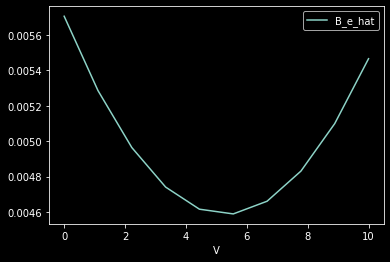

In [9]:
fig,ax=plt.subplots()
result.plot(x='V',y='B_e_hat', ax=ax)


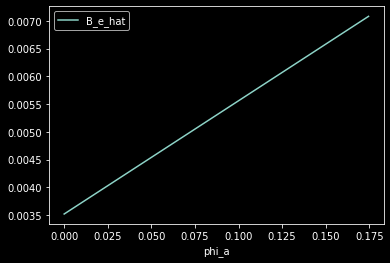

In [10]:
inputs2 = inputs.copy()
inputs2['V']=5
inputs2['phi_a']=np.deg2rad(np.linspace(0,10,N))
result2 = inputs2.apply(func=get_rolldamping, axis=1)

fig,ax=plt.subplots()
result2.plot(x='phi_a',y='B_e_hat', ax=ax)





### Using POST instead
...to request roll damping for many ships in one single request

In [11]:
def get_rolldampings(inputs):


    input_list = [record for record in inputs.to_dict('records')]
    response = requests.post(url=url,
                             json=input_list)

    outputs = response.json()
    outputs
    result = pd.DataFrame(outputs)
    return result

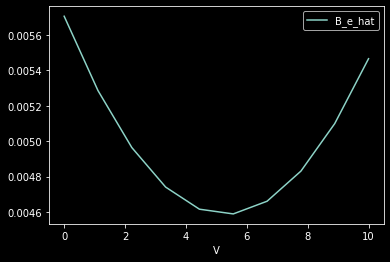

In [12]:
result3 = get_rolldampings(inputs=inputs)
fig,ax=plt.subplots()
result3.plot(x='V',y='B_e_hat', ax=ax)


## Playing with the API

In [13]:
X=polynom.X
X.head()

,beam,T,BK_L,BK_B,OG,omega0_hat,C_b,A_0,V,phi_a
0,0.157706,0.033692,0.238387,0.001577,-0.010466,0.730187,0.738415,0.9906,0.615980,0.0
1,0.165387,0.040493,0.324401,0.001514,-0.024225,0.518472,0.759250,0.9899,0.396847,0.0
2,0.159028,0.039931,0.314410,0.001389,-0.020486,0.517297,0.752774,0.9900,0.003031,0.0
3,0.263112,0.092057,0.000000,0.000000,-0.016512,0.468145,0.760157,0.9940,0.000000,0.0
4,0.159028,0.039931,0.314410,0.001389,-0.020486,0.513234,0.752774,0.9900,0.424395,0.0


/Users/martinalexandersson/Dev/REST_API_roll_damping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


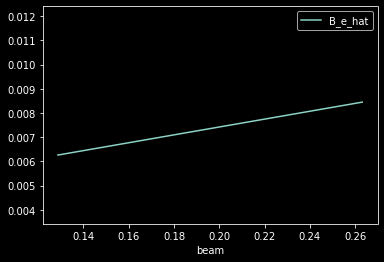

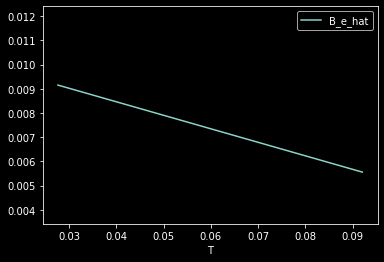

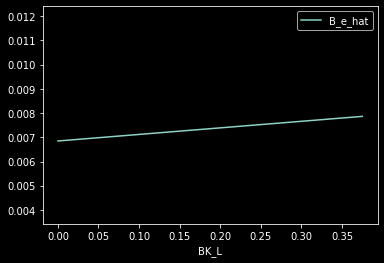

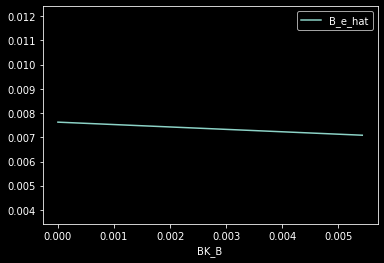

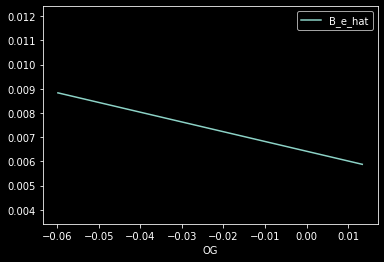

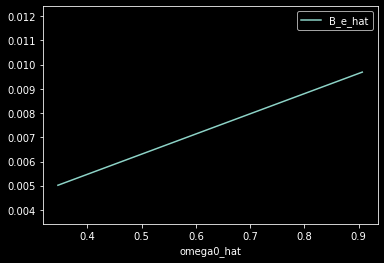

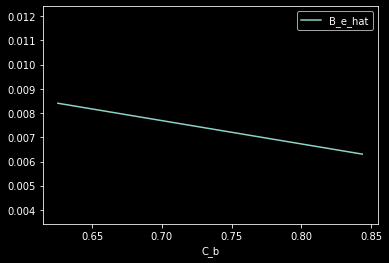

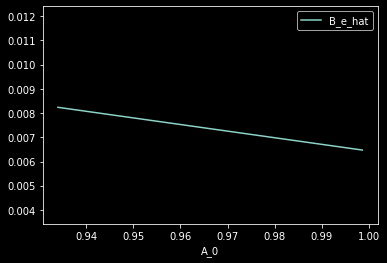

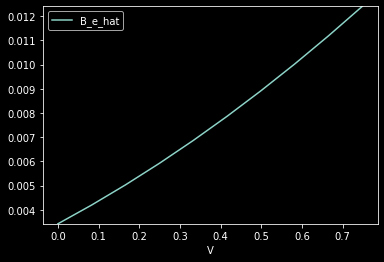

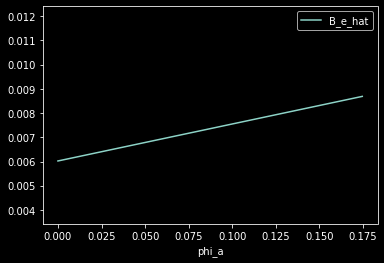

In [14]:
input_ranges = OrderedDict()
input_parameters=[
    'beam', 'T', 'BK_L', 'BK_B', 'OG', 'omega0_hat', 'C_b', 'A_0', 'V', 'phi_a'
]
for input_parameter in input_parameters:
    x=X[input_parameter]
    input_ranges[input_parameter]=(x.min(),x.max())

mean_ship = pd.Series()
for parameter, limits in input_ranges.items():
    mean_ship[parameter]=np.mean(limits)
mean_ship['lpp']=1

N=10
df_results=pd.DataFrame()
axes = []
for parameter, limits in input_ranges.items():

    repeats = np.tile(mean_ship, (N,1))
    df = pd.DataFrame(repeats, columns=mean_ship.index)
    df[parameter] = np.linspace(limits[0],limits[1],N)

    result4 = get_rolldampings(inputs=df)
    df_results=df_results.append(result4, ignore_index=True)

    fig,ax=plt.subplots()
    axes.append(ax)
    result4.plot(x=parameter, y='B_e_hat', ax=ax)

for ax in axes:
    ax.set_ylim(df_results['B_e_hat'].min(), df_results['B_e_hat'].max())

